In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [26]:
data = pd.read_csv('../data/S&P 500 Real Estate 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data

,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations
0,2002-02-11,1111.94,92.480003,1.719816,-1.648406,-1.648405845457901,178.500,149.000,179.000,206.300,207.300
1,2002-02-12,1107.50,91.610001,1.467732,-2.407587,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
2,2002-02-13,1118.51,91.989998,3.919838,-1.950546,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
3,2002-02-14,1116.48,92.470001,4.789526,-0.953299,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
4,2002-02-15,1104.18,93.330002,2.531293,-0.849883,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
...,...,...,...,...,...,...,...,...,...,...,...
4858,2021-11-24,4701.46,306.609985,4.852728,4.852599,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4859,2021-11-26,4594.62,298.359985,1.616263,2.854384,OUTPERFORM,280.126,210.452,288.259,341.963,326.397
4860,2021-11-29,4655.27,302.339996,1.484354,1.804830,OUTPERFORM,280.126,210.452,288.259,341.963,326.397
4861,2021-11-30,4567.00,295.940002,1.396956,2.585965,OUTPERFORM,280.126,210.452,288.259,341.963,326.397


## Using all data (Best Model)

In [27]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
0,2002,2,2002-02-21,1080.95,91.989998,0.700558,-4.147132,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300,3
1,2002,3,2002-03-14,1153.04,97.040001,6.386669,-0.144062,UNDERPERFORM,179.300,150.000,179.500,207.000,208.000,3
2,2002,4,2002-04-11,1103.69,99.620003,11.580767,3.094283,UNDERPERFORM,179.500,149.700,179.800,207.400,208.700,3
3,2002,5,2002-05-09,1073.01,94.000000,30.878819,15.592720,UNDERPERFORM,179.600,149.700,180.000,207.800,208.600,3
4,2002,6,2002-06-13,1009.56,97.290001,7.301830,9.400653,OUTPERFORM,180.000,149.900,180.200,208.200,208.800,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,-2.530346,-2.892393,UNDERPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,-1.849766,-2.628052,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,-4.490556,-2.141081,OUTPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,-7.366228,-9.709011,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [28]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]

In [29]:
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,2,1080.95,91.989998,0.700558,-4.147132,178.5,149.0,179.0,206.3,207.3,3
1,3,1153.04,97.040001,6.386669,-0.144062,179.3,150.0,179.5,207.0,208.0,3
2,4,1103.69,99.620003,11.580767,3.094283,179.5,149.7,179.8,207.4,208.7,3
3,5,1073.01,94.000000,30.878819,15.592720,179.6,149.7,180.0,207.8,208.6,3
4,6,1009.56,97.290001,7.301830,9.400653,180.0,149.9,180.2,208.2,208.8,3


In [30]:
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]

In [31]:
dd.data_summary(original)

,Info
Rows,234
Columns,7
Size in Memory,12.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.46,0.50,2,126
month,int64,0,0,1,6,12,6.50,3.45,12,20
overall,float64,0,0,178.50,227.20,280.13,224.37,25.23,229,2
commodities,float64,0,0,149,179.83,210.45,175.58,13.51,221,3
housing,float64,0,0,179,220.83,288.26,226.17,28.15,232,2
shelters,float64,0,0,206.30,253.88,341.96,263.56,36.84,227,2
transportations,float64,0,0,207.30,270.18,333.37,268.78,37.51,229,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

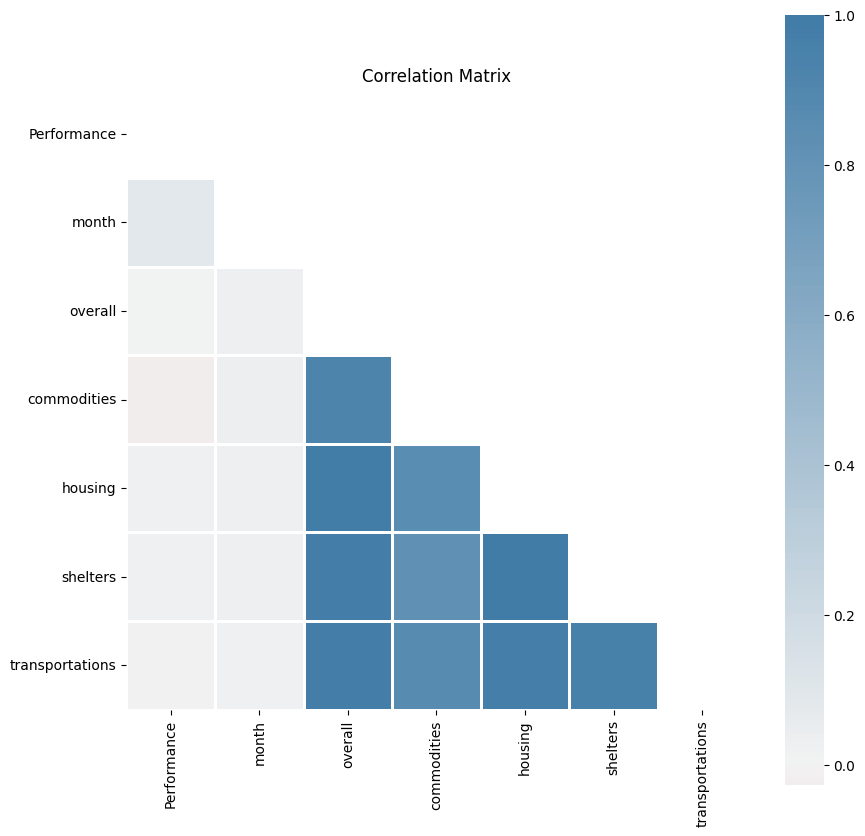

In [32]:
dd.correlation_matrix(original)

### Conditional GAN

In [33]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,11,3594.664181,151.116354,5.555352,3.161205,225.918830,184.467749,265.905050,263.618363,298.547452,3
1,8,951.930578,125.028788,-6.759261,-2.130623,195.801136,150.967174,187.528302,217.144269,196.182345,3
2,4,1982.192409,176.661298,14.496898,1.906012,232.160391,166.298469,266.906833,320.983389,302.659564,3
3,2,1407.910884,216.389253,-0.069047,5.898686,233.011052,182.169101,269.284495,253.146889,315.923093,3
4,6,1610.499145,169.203267,-0.172316,3.335869,234.818704,150.004328,223.451015,269.608648,263.930831,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1108.740408,143.276654,-7.479580,-6.032259,193.117298,151.557437,184.352611,206.639135,224.018262,3
9996,10,3514.630423,216.081133,-2.876697,5.769570,230.748497,182.536222,259.971387,310.848592,307.672512,3
9997,10,1125.521026,135.665779,0.245993,6.779633,233.538533,186.909639,220.121741,254.198359,259.355884,3
9998,3,998.712748,94.449376,61.369693,0.191923,155.229935,150.397859,177.887554,189.751545,222.499244,3


In [34]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [35]:
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
samples.head()

,Performance,month,overall,commodities,housing,shelters,transportations
0,0,11,225.918830,184.467749,265.905050,263.618363,298.547452
1,1,8,195.801136,150.967174,187.528302,217.144269,196.182345
2,0,4,232.160391,166.298469,266.906833,320.983389,302.659564
3,1,2,233.011052,182.169101,269.284495,253.146889,315.923093
4,1,6,234.818704,150.004328,223.451015,269.608648,263.930831


In [36]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.77,0.42,2,7680
month,int64,0,0,1,6,12,6.47,3.47,12,897
overall,float64,0,0,154.087,225.24,289.47,223.50,25.73,9999,2
commodities,float64,0,0,137.056,181.94,218.35,175.25,13.35,10000,1
housing,float64,0,0,168.51,223.44,307.52,228.29,28.31,9999,2
shelters,float64,0,0,183.23,258.50,360.74,266.93,35.34,10000,1
transportations,float64,0,0,187.40,268.65,345.035,268.046,36.36,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

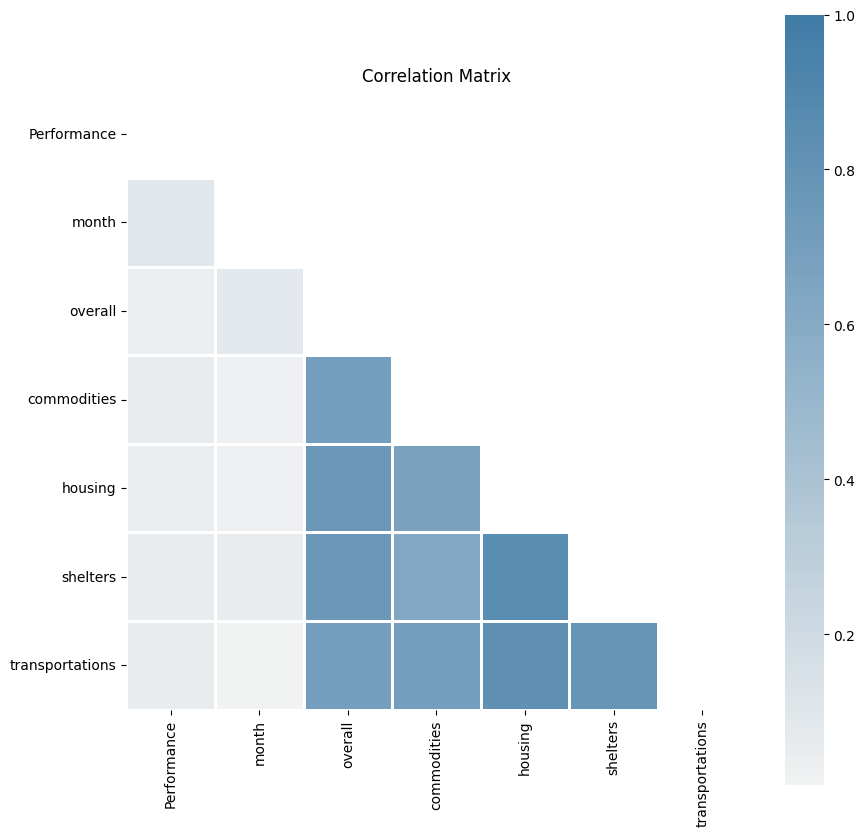

In [37]:
dd.correlation_matrix(samples)

In [38]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [39]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 7680, 0: 2320})
Counter({0: 7680, 1: 7680})


### Interaction Terms

In [40]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  225.91883034,   184.46774862,   265.90504994, ...,
        70097.45392496, 79385.27512968, 78702.59050804],
       [  195.80113633,   150.9671739 ,   187.52830155, ...,
        40720.69587015, 36789.74191155, 42599.87176011],
       [  232.16039147,   166.29846918,   266.90683321, ...,
        85672.65997328, 80781.90588021, 97148.69281733],
       ...,
       [  231.35222832,   181.52739444,   243.8306746 , ...,
        71539.00969233, 73450.27157111, 88381.15023722],
       [  260.33573891,   185.37456401,   267.38887141, ...,
        86304.78899251, 79723.39171191, 96235.21159571],
       [  182.60788327,   155.19578226,   187.98776488, ...,
        41579.21985299, 42461.91978653, 49959.35162598]])

In [41]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(15360, 16)

In [42]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(234, 16)

In [43]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [44]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.723698,0.807269,0.592708,0.682435,0.708594,0.78393,0.592347,0.674804,0.547009,0.509259,0.509259,0.509259
1,DecisionTreeClassifier,0.705339,0.728624,0.659115,0.691609,0.678385,0.704456,0.637245,0.669167,0.487179,0.454545,0.555556,0.5
2,RandomForestClassifier,0.825065,0.866543,0.773958,0.816451,0.79974,0.844021,0.745408,0.791655,0.5,0.469799,0.648148,0.544747
3,AdaBoostClassifier,0.601367,0.621844,0.521615,0.566768,0.592187,0.621305,0.514796,0.563058,0.529915,0.490741,0.490741,0.490741
4,GradientBoostingClassifier,0.631901,0.655297,0.561458,0.604241,0.619271,0.652387,0.543878,0.593211,0.564103,0.528846,0.509259,0.518868
5,ExtraTreesClassifier,0.855013,0.889078,0.815365,0.849614,0.827083,0.861607,0.787755,0.823028,0.521368,0.487013,0.694444,0.572519
6,BaggingClassifier,0.756185,0.832712,0.645573,0.726423,0.74349,0.816353,0.641837,0.718652,0.547009,0.508475,0.555556,0.530973
7,SVC,0.604883,0.610983,0.58112,0.595404,0.598958,0.620137,0.553061,0.584682,0.555556,0.519608,0.490741,0.504762
8,GaussianNB,0.544141,0.537884,0.626172,0.57861,0.545573,0.547757,0.629082,0.585609,0.512821,0.478261,0.611111,0.536585


### Voting Classifier

In [45]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.80599,0.841868,0.763265,0.800642


## Using data after 2010

In [46]:
data = pd.read_csv('../data/S&P 500 Real Estate 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
95,2010,1,2010-01-14,1148.46,94.040001,-2.110431,-9.707154,UNDERPERFORM,217.281,174.321,216.042,247.997,257.050,3
96,2010,2,2010-02-11,1078.47,86.949997,-11.020997,-22.108753,UNDERPERFORM,217.353,174.137,216.146,247.914,257.804,3
97,2010,3,2010-03-11,1150.24,99.019997,5.750719,-2.654349,UNDERPERFORM,217.403,173.874,216.092,247.959,258.306,3
98,2010,4,2010-04-08,1186.44,105.040001,6.168177,-2.460768,UNDERPERFORM,217.290,173.367,216.128,248.128,258.969,3
99,2010,5,2010-05-13,1157.44,109.879997,3.805347,-0.118176,UNDERPERFORM,217.199,172.929,216.060,248.295,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,-2.530346,-2.892393,UNDERPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,-1.849766,-2.628052,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,-4.490556,-2.141081,OUTPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,-7.366228,-9.709011,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [47]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,1,2750.595936,189.174465,-7.688442,0.861804,228.595721,186.308764,253.578488,262.776682,282.679681,3
1,1,3135.036317,170.275714,-5.075292,-0.084969,241.676316,180.165173,260.869804,319.624874,284.407065,3
2,4,1679.504232,193.302118,-6.501027,2.883421,239.737069,176.732633,235.563013,271.518159,298.456827,3
3,12,1470.221260,192.699241,-1.841010,-2.805287,233.166723,184.125575,231.472155,272.973695,292.272915,3
4,9,1984.376875,122.278680,-4.854221,-2.322473,227.409482,186.102247,224.493934,259.863669,276.861508,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,4,1833.914138,225.768535,0.243625,0.953665,230.399878,180.163766,233.124994,266.868664,285.734645,3
9996,1,1507.326503,165.851631,-7.162744,-6.571536,228.454232,186.163268,224.571716,265.357824,275.765083,3
9997,5,1961.797569,185.426823,-4.703967,-1.252913,221.986829,177.963805,218.082174,246.893109,275.954499,3
9998,1,1177.202192,144.199939,-5.430597,-3.375797,222.646352,182.484548,217.715746,262.882208,268.571318,3


In [48]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.638423,0.657496,0.594497,0.623061,0.627478,0.641347,0.564438,0.60044,0.510791,0.454545,0.396825,0.423729
1,DecisionTreeClassifier,0.623554,0.633724,0.607478,0.618331,0.607314,0.610058,0.576844,0.592986,0.503597,0.459459,0.539683,0.49635
2,RandomForestClassifier,0.700797,0.726097,0.672245,0.694484,0.676692,0.690566,0.6306,0.659222,0.496403,0.440678,0.412698,0.42623
3,AdaBoostClassifier,0.630812,0.635023,0.615863,0.625233,0.622351,0.627019,0.58856,0.607181,0.510791,0.462687,0.492063,0.476923
4,GradientBoostingClassifier,0.643287,0.649737,0.623372,0.636135,0.637389,0.642753,0.6051,0.623358,0.539568,0.492063,0.492063,0.492063
5,ExtraTreesClassifier,0.714213,0.743068,0.690015,0.710298,0.69583,0.703408,0.668504,0.685512,0.453237,0.4,0.412698,0.40625
6,BaggingClassifier,0.656789,0.693597,0.576889,0.627872,0.642857,0.670017,0.551344,0.604915,0.52518,0.47619,0.47619,0.47619
7,SVC,0.622866,0.626081,0.610559,0.618093,0.627478,0.627023,0.614059,0.620474,0.517986,0.472222,0.539683,0.503704
8,GaussianNB,0.574164,0.589345,0.489576,0.534681,0.563568,0.573604,0.467264,0.515002,0.589928,0.55,0.52381,0.536585
